# Training of the Neural Network

### In this notebook, the neural network from the paper is constructed and trained on a data subset 'Train_sub.csv'.

In [1]:
# Import
import pandas as pd 
import scipy.ndimage
import scipy.signal
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import os
from sklearn.preprocessing import StandardScaler           
from sklearn.model_selection import train_test_split        
from sklearn.metrics import accuracy_score
import joblib as jb
from time import time
import glob
import skfmm
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(42)

### Load data from .csv file and check the structure. 'head_diff' is the simulated head differences that we want to train the neural network to predict. These values are target data, while the remaining columns are used af input features.

In [2]:
data_collection = pd.read_csv('Train_sub.csv')
print(data_collection)

           head_diff         head          dist           time     dist_well  \
0       1.872103e+00  1317.703197   1573.723027      76.418131    -88.388348   
1       5.224641e-01  1294.126078   7605.546692      41.734163    -88.388348   
2       4.676374e+00  1237.888684   3994.917952     307.432679    -88.388348   
3       4.355244e+01  1180.976960    591.318456      74.482036    -88.388348   
4       3.138261e+01  1282.674114   1122.243424     418.531152    -88.388348   
...              ...          ...           ...            ...           ...   
283279  1.245266e-06  1259.621139  12720.084221  174249.798917  85470.924736   
283280  2.184873e-06  1282.942527  12864.142773  215469.315504  85897.565487   
283281  1.444064e-06  1296.432742  14396.070860  223816.682425  86296.839399   
283282  2.225960e-06  1298.854621  14735.019025  193333.001631  86687.341884   
283283  6.783698e-07  1253.668232  12751.463566  217922.169676  87419.122736   

         h_cond  h_cond_log  
0       1

### Split data into training, test, and validation data and scale the data using the StandardScaler() function

In [3]:
X_train1, X_test, y_train1, y_test = train_test_split(data_collection.iloc[:,1:7], data_collection.iloc[:,0], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.1, random_state=1)

In [4]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### The neural network is constructed using tensorflow.keras layers. Input has 6 features that are connected to 3 hidden layers with 75 neurons each. We add a probabilistic output layer with tensorflow probability and predicts two output values - the mean and standard deviation of the output distribution. The optimizer is Adam and we try to minimize the negative log-likelihood loss function

In [5]:
from keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions
negloglik = lambda y, p_y: -p_y.log_prob(y)

inputA = Input(shape=(6,),name='inputA')

interpB = Dense(75, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001), activity_regularizer=tf.keras.regularizers.l2(0.0001))(inputA)
interp1B = Dense(75, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001), activity_regularizer=tf.keras.regularizers.l2(0.0001))(interpB)
interp2B = Dense(75, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001), activity_regularizer=tf.keras.regularizers.l2(0.0001))(interp1B)
output = Dense(1+1, activation='linear')(interp2B)
outputs =  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])))(output)

model = Model(inputs=inputA, outputs=outputs)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=20000,
    decay_rate=0.95)
model.compile(optimizer = keras.optimizers.Adam(
    learning_rate=lr_schedule), loss=negloglik)
model.summary()

Using TensorFlow backend.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputA (InputLayer)          [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 75)                525       
_________________________________________________________________
dense_1 (Dense)              (None, 75)                5700      
_________________________________________________________________
dense_2 (Dense)              (None, 75)                5700      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 152       
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 12,077
Trainable params: 12,077
Non-trainable params: 0
_________________________________________________________

In [6]:
results=model.fit(X_train,y_train,batch_size=256,epochs=300,validation_data=(X_test,y_test))

Train on 203964 samples, validate on 56657 samples
Epoch 1/300
203964/203964 [==============================] - 3s 14us/sample - loss: 0.3903 - val_loss: -0.3205
Epoch 2/300
203964/203964 [==============================] - 2s 8us/sample - loss: -0.6618 - val_loss: -0.6559
Epoch 3/300
203964/203964 [==============================] - 2s 8us/sample - loss: -1.1275 - val_loss: -1.3379
Epoch 4/300
203964/203964 [==============================] - 2s 8us/sample - loss: -1.2807 - val_loss: -1.2144
Epoch 5/300
203964/203964 [==============================] - 2s 8us/sample - loss: -1.3921 - val_loss: -1.5501
Epoch 6/300
203964/203964 [==============================] - 2s 7us/sample - loss: -1.2472 - val_loss: -1.3531
Epoch 7/300
203964/203964 [==============================] - 2s 8us/sample - loss: -1.5634 - val_loss: -1.6309
Epoch 8/300
203964/203964 [==============================] - 2s 9us/sample - loss: -1.5184 - val_loss: -1.6236
Epoch 9/300
203964/203964 [==============================] - 

### Predict the head change from the validation data set and visiualize the results compared to the goal values. 

In [7]:
import time 
t1 = time.time()
X_val = scaler.transform(X_val)
y_hat = model(X_val)
mean = y_hat.mean()
stddev = y_hat.stddev()
t2 = time.time()
print('This took {} seconds'.format(round(t2-t1,2)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

This took 0.04 seconds


MSE: 0.9544
RMSE: 0.977


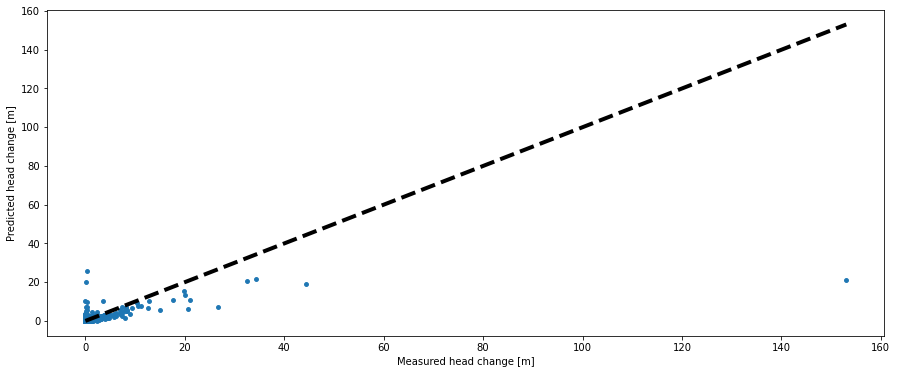

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

y_testi = y_val
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(y_testi, mean,s=15)
ax.plot([y_testi.min(), y_testi.max()], [y_testi.min(), y_testi.max()], 'k--', lw=4)
#ax.set_xlim([-5,20])#
#ax.set_ylim([-5,20])
ax.set_xlabel('Measured head change [m]')
ax.set_ylabel('Predicted head change [m]')
#plt.show()
fig.savefig('Validation')

MSE = mean_squared_error(y_testi,mean) #Mean square of the residuals
print("MSE: {}" .format(round((MSE), 4))) #Root mean square error
print("RMSE: {}" .format(round(np.sqrt(MSE), 4))) #Root mean square error

### The network can be saved and loaded again for further use elsewhere

In [9]:
#model.save("Trained_network_sub.h5")
print("Saved model to disk")

Saved model to disk


### Feel free to play around with the model and investigate the effects of more epocs, different number of hidden layers, or number of neurons.